# Imports & Visualisation Functions

In [1]:
from ast import Param

from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.core import ConcreteModel
from pyomo.common.config import PositiveInt

import os
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go

In [2]:
os.environ["NEOS_EMAIL"] = "antonsivko480@gmail.com"

In [3]:
def plot_tsp_tour(coords, tour, title=None, show_positions=True):
    """
    coords: dict {node: (x, y)}
    tour: список вершин у порядку обходу, наприклад [1, 23, 38, ..., 1]
          якщо останній елемент не дорівнює першому, ми автоматично замкнемо тур
    show_positions: якщо True — підписуємо вершини як "node (step)"
    """

    if tour[0] != tour[-1]:
        tour = list(tour) + [tour[0]]

    start = tour[0]

    position_in_tour = {
        node: idx for idx, node in enumerate(tour[:-1])
    }

    if not isinstance(coords, dict):
        coords = {i: (coords[i][0], coords[i][1]) for i in range(len(coords))}

    plt.figure(figsize=(10, 10))

    for k in range(len(tour) - 1):
        i = tour[k]
        j = tour[k+1]
        x_i, y_i = coords[i]
        x_j, y_j = coords[j]

        dx = x_j - x_i
        dy = y_j - y_i

        plt.arrow(x_i, y_i, dx, dy, length_includes_head=True, head_width=1, head_length=1.75, linewidth=1.0, alpha=0.8, zorder=1)

        # plt.plot([x_i, x_j], [y_i, y_j], color="gray", linewidth=1, zorder=1)

    xs = [coords[i][0] for i in coords]
    ys = [coords[i][1] for i in coords]
    plt.scatter(xs, ys, s=30, color="blue", zorder=2, label="Other Nodes")

    x_s, y_s = coords[start]
    plt.scatter([x_s], [y_s], s=120, color="red", edgecolors="black", zorder=3, label="Start Node")

    for node, (x, y) in coords.items():
        if show_positions and node in position_in_tour:
            step = position_in_tour[node]
            text = f"{node} ({step})"
        else:
            text = str(node)
        plt.text(x, y, text, fontsize=10, ha="right", va="bottom")

    plt.title(title if title else "TSP Tour")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [4]:
# solver = SolverFactory(
#     "cbc",
#     executable=r"C:\Users\Antonio\Desktop\New folder\bin\cbc.exe"
# )
# print("Is solver available? ->", solver.available())
# print("Is solver executable? ->", solver.executable())


# Base Paramethers & Data

## Base Params (st70)

In [5]:
n_value = 70
s_value = 1
k_value = 20

## # st70 Coordinates


In [6]:
# xcoord_list = [
#     64, 80, 69, 72, 48, 58, 81, 79, 30, 42,
#     7, 29, 78, 64, 95, 57, 40, 68, 92, 62,
#     28, 76, 67, 93, 6, 87, 30, 77, 78, 55,
#     82, 73, 20, 27, 95, 67, 48, 75, 8, 20,
#     54, 63, 44, 52, 12, 25, 58, 5, 90, 41,
#     25, 37, 56, 10, 98, 16, 89, 48, 81, 29,
#     17, 5, 79, 9, 17, 74, 10, 48, 83, 84,
# ]
#
# ycoord_list = [
#     96, 39, 23, 42, 67, 43, 34, 17, 23, 67,
#     76, 51, 92, 8, 57, 91, 35, 40, 34, 1,
#     43, 73, 88, 54, 8, 18, 9, 13, 94, 3,
#     88, 28, 55, 43, 86, 99, 83, 81, 19, 18,
#     38, 36, 33, 18, 13, 5, 85, 67, 9, 76,
#     76, 64, 63, 55, 7, 74, 60, 82, 76, 60,
#     22, 45, 70, 100, 82, 67, 68, 19, 86, 94,
# ]
#
# xcoord_data = {i + 1: xcoord_list[i] for i in range(n_value)}
# ycoord_data = {i + 1: ycoord_list[i] for i in range(n_value)}

In [7]:
n_value = 100

xcoord_list = [
    86, 19, 8, 40, 36, 33, 22, 18, 91, 74,
    16, 80, 59, 9, 8, 16, 32, 34, 69, 82,
    8, 76, 30, 96, 88, 94, 74, 58, 33, 62,
    80, 40, 5, 25, 94, 59, 48, 40, 24, 32,
    48, 18, 16, 53, 17, 50, 49, 82, 38, 10,
    98, 63, 73, 20, 53, 15, 75, 42, 85, 84,
    51, 78, 29, 95, 13, 10, 89, 34, 42, 15,
    34, 17, 53, 40, 63, 86, 51, 25, 52, 50,
    31, 90, 39, 94, 92, 87, 14, 82, 86, 26,
    73, 98, 36, 25, 64, 53, 39, 86, 93, 76,
]

ycoord_list = [
    29, 88, 42, 99, 100, 8, 30, 5, 41, 52,
    35, 9, 28, 73, 92, 41, 28, 84, 64, 51,
    83, 59, 19, 34, 18, 32, 96, 72, 69, 34,
    96, 75, 55, 75, 52, 47, 29, 18, 66, 64,
    12, 97, 7, 15, 20, 81, 21, 88, 55, 77,
    9, 50, 49, 77, 60, 68, 33, 71, 2, 88,
    93, 15, 88, 69, 97, 35, 99, 83, 44, 15,
    38, 56, 21, 59, 1, 93, 93, 34, 65, 98,
    23, 65, 14, 81, 39, 82, 65, 78, 26, 20,
    48, 98, 21, 70, 100, 68, 1, 77, 42, 63,
]

xcoord_data = {i + 1: xcoord_list[i] for i in range(n_value)}
ycoord_data = {i + 1: ycoord_list[i] for i in range(n_value)}


## Distance


In [8]:
d_data = {}

for i in range(1, n_value + 1):
    for j in range(1, n_value + 1):
        if i != j:
            dx = xcoord_data[i] - xcoord_data[j]
            dy = ycoord_data[i] - ycoord_data[j]
            dist = math.hypot(dx, dy)
            d_data[(i, j)] = int(round(dist, 2))

# print("d_data:", d_data)

# Pyomo Model

In [9]:
model = ConcreteModel()

## Model Parameters


In [10]:
model.n = Param(initialize=n_value, within=PositiveIntegers)
model.s = Param(initialize=s_value, within=PositiveIntegers)
model.k = Param(initialize=k_value, within=PositiveIntegers)

## Nodes & Arcs


In [11]:
model.NODES = RangeSet(1, model.n)

def arcs_init(model):
    return [(i, j) for i in model.NODES for j in model.NODES if i != j]

model.ARCS = Set(dimen=2, initialize=arcs_init)

## x_coord, y_coord, d


In [12]:
model.x_coord = Param(model.NODES, initialize=xcoord_data)
model.y_coord = Param(model.NODES, initialize=ycoord_data)

model.d = Param(model.ARCS, within=NonNegativeReals, initialize=d_data)

## x, y, z, u variables


In [13]:
model.x = Var(model.ARCS, domain=Binary)
model.y = Var(model.NODES, domain=Binary)
model.z = Var(model.ARCS, domain=NonNegativeReals)

def u_bounds(m, i):
    return (1, m.k)

model.u = Var(model.NODES, domain=Integers, bounds=u_bounds)

## Target Function


In [14]:
def dk_min_rule(m):
    return sum(m.d[i, j] * m.x[i, j] for (i, j) in m.ARCS)

model.dk_min = Objective(rule=dk_min_rule, sense=minimize)

## con2 - con4


In [15]:
def con2_rule(m, i):
    if i == m.s:
        rhs = 1
    else:
        rhs = m.y[i]
    return sum(m.x[i, j] for j in m.NODES if (i, j) in m.ARCS) == rhs

model.con2 = Constraint(model.NODES, rule=con2_rule)

def con3_rule(m, i):
    if i == m.s:
        rhs = 1
    else:
        rhs = m.y[i]
    return sum(m.x[j, i] for j in m.NODES if (j, i) in m.ARCS) == rhs

model.con3 = Constraint(model.NODES, rule=con3_rule)

def con4_rule(m):
    return sum(m.y[i] for i in m.NODES if i != m.s) == m.k

model.con4 = Constraint(rule=con4_rule)

## Flow-based Part (con5 - con7)

In [16]:
def con5_rule(m, i, j):
    return m.z[i, j] - m.k * m.x[i, j] <= 0

model.con5 = Constraint(model.ARCS, rule=con5_rule)

def con6_1_rule(m):
    # Maybe a problem later
    s = value(m.s)
    return sum(m.z[m.s, j] for j in m.NODES if (s, j) in m.ARCS) == m.k

model.con6_1 = Constraint(rule=con6_1_rule)

def con6_2_rule(m):
    # Maybe a problem later
    s = value(m.s)
    return sum(m.z[j, m.s] for j in m.NODES if (j, s) in m.ARCS) == 0

model.con6_2 = Constraint(rule=con6_2_rule)

def con7_rule(m, i):
    if i == m.s:
        return Constraint.Skip
    outgoing = sum(m.z[i, j] for j in m.NODES if (i, j) in m.ARCS)
    incoming = sum(m.z[j, i] for j in m.NODES if (j, i) in m.ARCS)
    return outgoing - incoming == -m.y[i]

model.con7 = Constraint(model.NODES, rule=con7_rule)

## MTZ Part (con15)

In [17]:
def con15_rule(m, i, j):
    if i == m.s or j == m.s:
        return Constraint.Skip
    return m.u[i] - m.u[j] + m.k * m.x[i, j] <= m.k - 1

model.con15 = Constraint(model.ARCS, rule=con15_rule)

# Solver Part

In [18]:
# Connect NEOS Server

neos = SolverManagerFactory("neos")

## Problem 1 - Flow-based model

Problem 1 (Flow-based):
dk_min (problem1) = 146.0
Display x (problem1):
Node: 1 -> To Node: 89
Node: 9 -> To Node: 99
Node: 10 -> To Node: 53
Node: 22 -> To Node: 10
Node: 24 -> To Node: 85
Node: 26 -> To Node: 24
Node: 35 -> To Node: 82
Node: 48 -> To Node: 88
Node: 53 -> To Node: 91
Node: 57 -> To Node: 1
Node: 60 -> To Node: 48
Node: 64 -> To Node: 98
Node: 82 -> To Node: 64
Node: 85 -> To Node: 9
Node: 86 -> To Node: 60
Node: 88 -> To Node: 100
Node: 89 -> To Node: 26
Node: 91 -> To Node: 57
Node: 98 -> To Node: 86
Node: 99 -> To Node: 35
Node: 100 -> To Node: 22
Reconstructed tour: [1, 89, 26, 24, 85, 9, 99, 35, 82, 64, 98, 86, 60, 48, 88, 100, 22, 10, 53, 91, 57, 1]


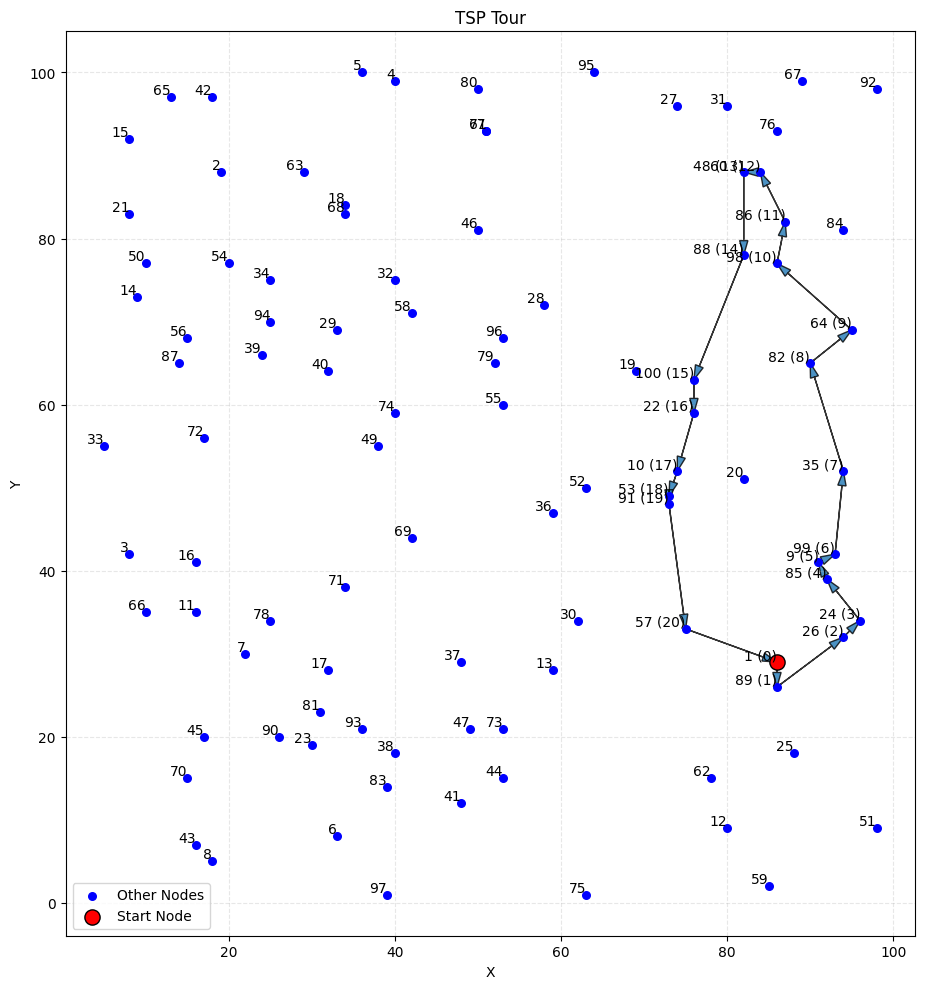

In [19]:
print("Problem 1 (Flow-based):")

# con5-con7 is active
model.con5.activate()
model.con6_1.activate()
model.con6_2.activate()
model.con7.activate()

# con15 deactivate
model.con15.deactivate()

results1 = neos.solve(model, opt="cplex", tee=False)

if (results1.solver.status == SolverStatus.ok and
    results1.solver.termination_condition in [TerminationCondition.optimal,
                                              TerminationCondition.feasible]):

    t1 = getattr(results1.solver, "time", None)
    if t1 is not None:
        print("Solve time (problem1):", t1)

    print("dk_min (problem1) =", value(model.dk_min))

    selected_edges = []
    print("Display x (problem1):")
    for i in model.NODES:
        for j in model.NODES:
            if (i, j) in model.ARCS:
                x_val = value(model.x[i, j])
                if x_val >= 0.5:
                    selected_edges.append((i, j))
                    print(f"Node: {i} -> To Node: {j}")

    succ = {i: j for (i, j) in selected_edges}
    start = value(model.s)
    tour = [start]
    current = start

    while True:
        current = succ[current]
        tour.append(current)
        if current == start:
            break
        if len(tour) > len(model.NODES) + 1:
            print("Warning: tour reconstruction looks wrong (too long).")
            break

    print("Reconstructed tour:", tour)

    coords = {i: (xcoord_data[i], ycoord_data[i]) for i in model.NODES}

    plot_tsp_tour(coords, tour)

else:
    print("The solution for problem 2 was not found or is not optimal — see the status above.")


## Problem 2 - MTZ model

In [20]:
# print("\nProblem 2 (MTZ):")
#
# # con5-con7 is inactive
# model.con5.deactivate()
# model.con6_1.deactivate()
# model.con6_2.deactivate()
# model.con7.deactivate()
#
# # con15 is active
# model.con15.activate()
#
# results2 = neos.solve(model, opt="cplex", tee=False)
#
# if (results2.solver.status == SolverStatus.ok and
#     results2.solver.termination_condition in [TerminationCondition.optimal,
#                                               TerminationCondition.feasible]):
#
#     print("dk_min (problem2) =", value(model.dk_min))
#
#     selected_edges_2 = []
#     print("Display x (problem2):")
#     for i in model.NODES:
#         for j in model.NODES:
#             if (i, j) in model.ARCS:
#                 x_val = value(model.x[i, j])
#                 if x_val is not None and x_val >= 0.5:
#                     selected_edges_2.append((i, j))
#                     print(f"Node: {i} -> To Node: {j}")
#
#     print("Display u (problem 2):")
#
#     for i in model.NODES:
#         yi = model.y[i].value
#         if yi is not None and yi > 0.5:
#             print(f"Node: {i}\tSequence Number:{int(model.u[i].value)}")
#
#     print("Display sorted u (problem 2):")
#
#     selected_u = []
#     for i in model.NODES:
#         yi = model.y[i].value
#         if yi is None:
#             continue
#         if yi > 0.5:
#             u_val = model.u[i].value
#             if u_val is not None:
#                 selected_u.append((i, u_val))
#
#     selected_u.sort(key=lambda t: t[1])
#
#     for i, u in selected_u:
#         out = int(u) if float(u).is_integer() else u
#         print(f"Node: {i}\tSequence Number:{out}")
#
#     succ2 = {i: j for (i, j) in selected_edges_2}
#
#     start2 = value(model.s)
#     tour2 = [start2]
#     current = start2
#
#     while True:
#         current = succ2[current]
#         tour2.append(current)
#         if current == start2:
#             break
#         if len(tour2) > len(model.NODES) + 1:
#             print("Warning: tour reconstruction looks wrong (too long).")
#             break
#
#     print("Reconstructed tour:", tour)
#
#     coords = {i: (xcoord_data[i], ycoord_data[i]) for i in model.NODES}
#
#     labels = {i: f"{i} (u={int(u)})" for i, u in selected_u}
#     plot_tsp_tour(coords, tour2)
#
# else:
#     print("The solution for problem 2 was not found or is not optimal — see the status above.")


## Problem 3 - Hybrid

Problem 3 (Hybrid):
dk_min (problem3): 146.0
Display x (problem3):
Node: 1 -> To Node: 89
Node: 9 -> To Node: 99
Node: 10 -> To Node: 53
Node: 22 -> To Node: 10
Node: 24 -> To Node: 85
Node: 26 -> To Node: 24
Node: 35 -> To Node: 82
Node: 48 -> To Node: 88
Node: 53 -> To Node: 91
Node: 57 -> To Node: 1
Node: 60 -> To Node: 48
Node: 64 -> To Node: 98
Node: 82 -> To Node: 64
Node: 85 -> To Node: 9
Node: 86 -> To Node: 60
Node: 88 -> To Node: 100
Node: 89 -> To Node: 26
Node: 91 -> To Node: 57
Node: 98 -> To Node: 86
Node: 99 -> To Node: 35
Node: 100 -> To Node: 22
Display u (problem 3):
Node: 9	Sequence Number:5
Node: 10	Sequence Number:17
Node: 22	Sequence Number:16
Node: 24	Sequence Number:3
Node: 26	Sequence Number:2
Node: 35	Sequence Number:7
Node: 48	Sequence Number:13
Node: 53	Sequence Number:18
Node: 57	Sequence Number:20
Node: 60	Sequence Number:12
Node: 64	Sequence Number:9
Node: 82	Sequence Number:8
Node: 85	Sequence Number:4
Node: 86	Sequence Number:11
Node: 88	Sequence Number

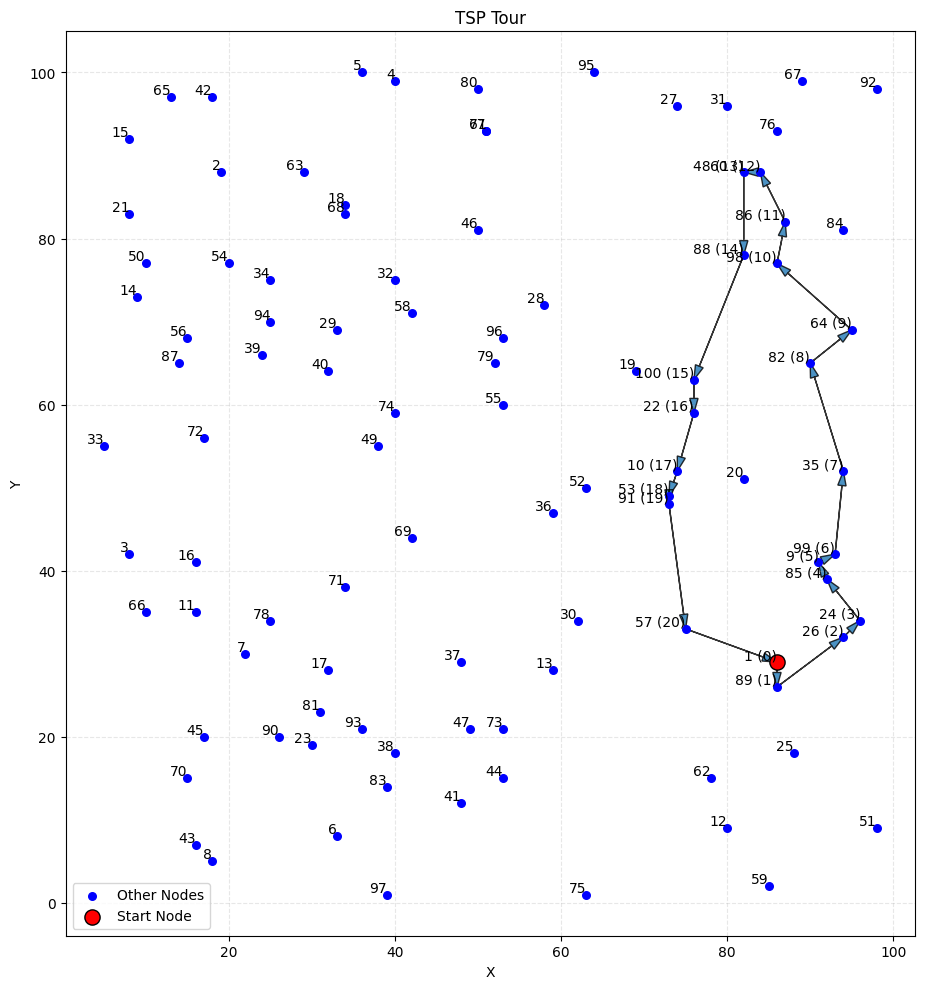

In [21]:
print("Problem 3 (Hybrid):")

model.con5.activate()
model.con6_1.activate()
model.con6_2.activate()
model.con7.activate()
model.con15.activate()

results3 = neos.solve(model, opt="cplex", tee=False)

if (results3.solver.status == SolverStatus.ok and results3.solver.termination_condition in [TerminationCondition.optimal, TerminationCondition.feasible
    ]):

    t3 = getattr(results3.solver, "time", None)
    if t3 is not None:
        print("Solve time (problem3):", t3)

    print("dk_min (problem3):", value(model.dk_min))

    selected_edges_3 = []
    print("Display x (problem3):")
    for i in model.NODES:
        for j in model.NODES:
            if (i, j) in model.ARCS:
                x_val = value(model.x[i, j])
                if x_val is not None and x_val >= 0.5:
                    selected_edges_3.append((i, j))
                    print(f"Node: {i} -> To Node: {j}")

    print("Display u (problem 3):")
    for i in model.NODES:
        yi = model.y[i].value
        if yi is not None and yi > 0.5:
            print(f"Node: {i}\tSequence Number:{int(model.u[i].value)}")

    print("Display sorted u (problem 3):")

    selected_u_3 = []
    for i in model.NODES:
        yi = model.y[i].value
        if yi is None:
            continue
        if yi > 0.5:
            u_val = model.u[i].value
            if u_val is not None:
                selected_u_3.append((i, u_val))

    selected_u_3.sort(key=lambda t: t[1])

    for i, u in selected_u_3:
        out = int(u) if float(u).is_integer() else u
        print(f"Node: {i}\tSequence Number:{out}")

    succ3 = {i: j for (i, j) in selected_edges_3}

    start3 = value(model.s)
    tour3 = [start3]
    current = start3

    while True:
        current = succ3[current]
        tour3.append(current)
        if current == start3:
            break
        if len(tour3) > len(model.NODES) + 1:
            print("Warning: tour reconstruction (problem 3) looks wrong (too long).")
            break

    print("Reconstructed tour (problem 3):", tour3)

    coords = {i: (xcoord_data[i], ycoord_data[i]) for i in model.NODES}

    plot_tsp_tour(coords, tour3)

else:
    print("NEOS failed")
    print("status:", results3.solver.status)
    print("termination condition:", results3.solver.termination_condition)